In [1]:
from IPython.display import Image

# **Projekt na zajęcia Algorytmy Uczenia Maszynowego, prowadzący dr. inż Piotr Ciskowski**
# **Twórcy: Adam Kubiak i Piotr Gorzelnik**
# **Projekt: Rozpoznawanie podstaw języka migowego w czasie rzeczywistym**

W ramach projektu wykorzystaliśmy zbiór danych, złożony z zdjęć dłoni, która reprezentuje jedną z 24 liter języka migowego(W alfabecie znajduje się 26 liter jednak litera "J" oraz "Z" jest reprezentowana poprzez ruch dłonią co wykracza poza założenia projektu). Zbiór danych zostaje wykorzystany do uczenia modelu Convolutional Neural Networks (CNN), Sequential, który jest dostępny w pakiecie o nazwie "keras". Dane uzykane zostały ze strony kaggle.com. Są one udostępnione w formie pliku .csv gdzie każdy pixel jest reprezentowany przez liczbe z zakresu 0-255, każde zdjęcie składa się z 784 pixeli(wymiary 28x28). Dodatkowo dołożyliśmy kilka dodatkowych znaków do wykorzystywanego zbioru danych. Projekt spełnia następujące zadania:

- Przygotowanie zbioru danych
- Przetworzenie zbioru aby spełniał wymagania modelu Sequential
- Przygotowanie modelu i ustawienie odpowiednich wartości jego parametrów
- Nauka modelu
- Sprawdzenie dokładności modelu z wykrzystaniem zbioru testowego danych
- Wykorzystanie biblioteki CV2 w celu zbierania zdjęć z kamery 
- Przetworznie pobranego obrazu z kamery
- Estymacja pokazywanego znaku przez użytkownika z wykorzystaniem wyuczonego modelu CNN

# ![title](ImagesNotebook\American-Sign-Language-alphabet-community-used-including-letters-from-A-to-Y-excluding.png)



#  **Importowanie pakietów wykorzystanych w projekcie**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# **Ładowanie i wstępne przetwarzanie zbioru danych**
Format zestawu danych jest wzorowany, aby ściśle odpowiadał klasycznemu MNIST. Każdy przypadek treningowy i testowy reprezentuje etykietę (0-25) jako mapę jeden do jednego dla każdej litery alfabetu A-Z (nie ma przypadków dla 9=J lub 25=Z ze względu na ruchy gestów). Dane treningowe (27 455 przypadków) i dane testowe (7172 przypadki). Wiersz danych w pliku .csv zawiera etykiete oraz pixel1,pixel2….pixel784, które w całości reprezentują pojedynczy obraz 28x28 pikseli z wartości w skali szarości z zakresu 0-255. Dodatkowe etykiety wybranych przez nas znaków są przetwarzane za pomocą napisanej funkcji, która bada wszystkie zdjęcia znajdujące się w podanym przez użytkownika folderze, a następnie przetwarza je do odpowiedniego formatu narzuconego przez podstawowy zbiór danych wraz z etykietą przypisaną przez użytkownika.


In [3]:
train_df=pd.read_csv('kaggle\sign_mnist_train.csv')
test_df=pd.read_csv('kaggle\sign_mnist_test.csv')


Prezentacja formatu pobranych danych z pliku .csv do struktury danych DataFrame z pakietu Pandas

In [4]:
train_df.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93
27454,23,179,180,180,180,182,181,182,183,182,...,108,132,170,194,214,203,197,205,209,215


Etykiety znajdujące się w DataFrame przed dodaniem własnych znaków do zbioru danych

In [5]:
df = train_df.iloc[:,0]
print(train_df.iloc[:,0].unique())

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


Funkcja mająca na celu przetworzenie zdjęć z dodatkowymi znakami języka migowego do formatu istniejącego DataFrame

In [6]:
def addDataToSet(path_folder, label_):
    i = 0
    path = os.path.join(path_folder)
    rows = len(os.listdir(path))
    finalImageList = np.zeros(shape=(rows,785))
    while i < len(os.listdir(path)):
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = np.mean(img_array,-1)
            #print(img.shape)
            img_array = scipy.ndimage.zoom(img_array,1/124)
            #plt.imshow(img_array, cmap='gray')
            img_array = img_array.reshape((1,784))
            img_array = np.insert(img_array, 0, int(label_), axis=1) # label
            img_array = np.around(img_array,decimals=0)
            img_array = img_array.astype(int)
            finalImageList[i] = (img_array)
            i+=1
    return finalImageList

Dołączenie dodatkowych znaków do zbioru uczącego

In [7]:
Datadirectory = "FAK"
label = 9
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
train_df = train_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_11508\4258792020.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df)


In [8]:
Datadirectory = "ILY"
label = 25
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
train_df = train_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_11508\3238422897.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df)


Dołączenie dodatkowych znaków do zbioru testowego

In [9]:
Datadirectory = "FAK_TEST"
label = 9
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
test_df = test_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_11508\1002997612.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(df)


In [10]:
Datadirectory = "ILY_TEST"
label = 25
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
test_df = test_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_11508\3401862683.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(df)


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27669 entries, 0 to 109
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 165.9 MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7251 entries, 0 to 39
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 43.5 MB


In [13]:
for col in test_df:
    test_df[col] = test_df[col].astype('int')
test_df.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
35,25,158,160,164,162,156,157,150,154,160,...,151,164,162,172,179,189,198,203,205,200
36,25,166,165,161,157,155,150,156,156,155,...,120,168,175,180,186,192,204,203,204,202
37,25,152,162,158,152,157,152,153,157,155,...,139,166,170,174,188,197,203,199,202,204
38,25,160,159,159,161,154,154,156,158,161,...,162,173,174,180,190,192,202,206,205,204
39,25,155,160,161,154,146,156,150,145,154,...,161,164,175,173,190,195,196,194,200,195


In [14]:
df = train_df.iloc[:,0]
#print(col)
print(train_df.iloc[:,0].unique())

[ 3.  6.  2. 13. 16.  8. 22. 18. 10. 20. 17. 19. 21. 23. 24.  1. 12. 11.
 15.  4.  0.  5.  7. 14.  9. 25.]


In [15]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,...,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000,27669.000000
mean,12.356753,145.434855,148.526474,151.256424,153.537497,156.169757,158.349272,160.410170,162.265604,163.889262,...,141.188550,147.576385,153.393292,159.165095,162.016517,162.804330,162.994506,162.080885,161.267122,159.932741
std,7.305953,41.217814,39.803059,38.916585,38.454202,36.976847,35.997933,34.892493,33.553920,32.543516,...,63.614358,65.374612,64.300854,63.603236,63.632662,63.339645,63.400896,63.188798,63.498181,64.294434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,122.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,145.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,126.000000
50%,13.000000,150.000000,153.000000,155.000000,158.000000,160.000000,162.000000,163.000000,165.000000,166.000000,...,144.000000,163.000000,173.000000,180.000000,183.000000,184.000000,184.000000,183.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,180.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,204.000000,207.000000,207.000000,207.000000,207.000000,206.000000,205.000000,204.000000
max,25.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Zestaw danych train_df zawiera pierwszą kolumnę reprezentującą etykiety od 1 do 24.
Etykiety są ładowane do oddzielnego DataFrame o nazwie „train_label”, a kolumna „etykieta” jest usuwana z oryginalnego DataFrame, który teraz zawiera tylko 784 wartości pikseli, które wchodzą w skład pojedyńczego obrazu.

In [16]:
train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)
trainset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107.0,118.0,127.0,134.0,139.0,143.0,146.0,150.0,153.0,156.0,...,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,155.0,157.0,156.0,156.0,156.0,157.0,156.0,158.0,158.0,157.0,...,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,187.0,188.0,188.0,187.0,187.0,186.0,187.0,188.0,187.0,186.0,...,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,211.0,211.0,212.0,212.0,211.0,210.0,211.0,210.0,210.0,211.0,...,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,164.0,167.0,170.0,172.0,176.0,179.0,180.0,184.0,185.0,186.0,...,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


Po wycięciu etykiet ze zbioru danych należy zmienić strukture danych z DataFrame do tablicy numpy który jest wykorzystywany podczas uczenia modelu CNN.
Macierze są konwertowane z 1-D na 3-D, co jest wymaganym wejściem do pierwszej warstwy CNN, z ciągu pixeli tworzymy macierz o wymiarze (28,28).
Przeprowadzane kroki dla zbioru uczącego, zostały także wykonane dla zbioru testowego w poniższych blokach kodu.

In [17]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27669, 28, 28, 1)


In [18]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(7251, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


**Konwersja etykiet liczb całkowitych do postaci binarnej**

Ramka danych etykiety składa się z pojedynczych wartości od 1 do 24 dla każdego pojedynczego obrazu. Warstwa wyjściowa CNN będzie składać się z 25 węzłów, ponieważ jako klasyfikator z wieloma etykietami ma 25 różnych etykiet. Stąd każda liczba całkowita jest zakodowana w tablicy binarnej o rozmiarze 25, przy czym odpowiadająca jej etykieta wynosi 1, a wszystkie inne etykiety są równe 0. Na przykład, jeśli y=4, tablica to [0 0 0 1 0 0.....0].
Do przeprowadzenia tej konswersji wykorzystaliśmy pakiet LabelBinarizer z pakietu sklearn.preprocessing.
# ![title](ImagesNotebook\sklprepro.png)


In [19]:
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [20]:
X_test=X_test.values.reshape(-1,28,28,1)

In [21]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27669, 28, 28, 1) (27669, 26) (7251, 28, 28, 1) (7251, 26)


**Rozszerzanie zbioru danych**

Pakiet ImageDataGenerator z pakietu keras.preprocessing.image umożliwia dodawanie różnych zniekształceń do zbioru danych obrazów poprzez zapewnienie losowego obracania, powiększania/pomniejszania, skalowania wysokości lub szerokości itp.
Zestaw danych obrazu jest tutaj również znormalizowany przy użyciu parametru rescale, który dzieli każdy piksel przez 255, tak że wartości pikseli mieszczą się w zakresie od 0 do 1.
Dodatkowo dane testowe są także są normalizowane jednak nie zastowaliśmy na nich operacji rozszerzania zbioru.

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

# **Przegląd danych wykorzystanych do nauki i testowania modelu CNN**

(-0.5, 27.5, 27.5, -0.5)

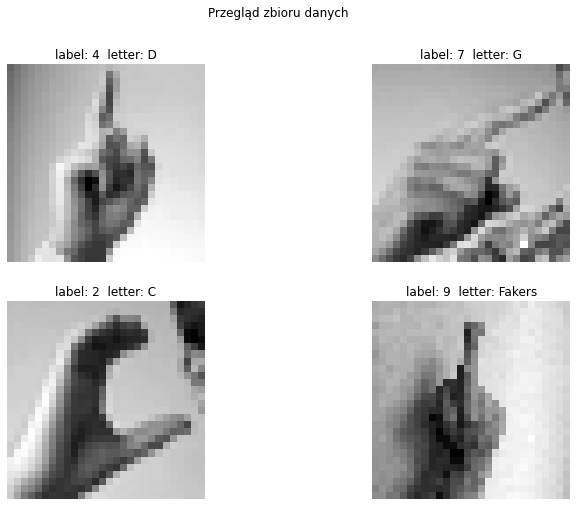

In [23]:
#plt.figure(figsize = (18,8))
fig,axe=plt.subplots(2,2,figsize = (12,8))
fig.suptitle('Przegląd zbioru danych')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 4  letter: D')
axe[0,0].axis('off')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 7  letter: G')
axe[0,1].axis('off')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: C')
axe[1,0].axis('off')
axe[1,1].imshow(X_train[27530].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 9  letter: Fakers')
axe[1,1].axis('off')

c:\Users\Adam\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Częstotliwość występowania każdej z etykiet')

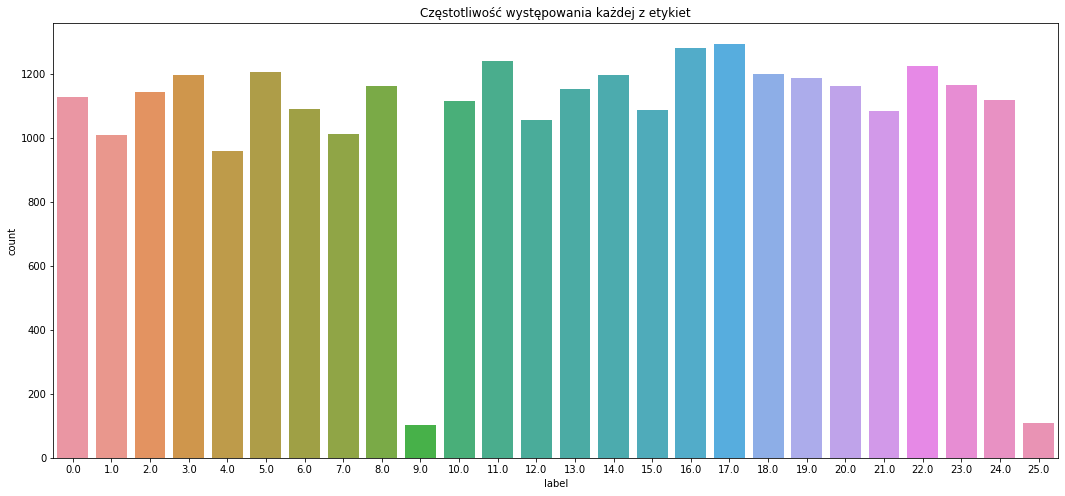

In [24]:
plt.figure(figsize = (18,8))
sns.countplot(train_label)
plt.title("Częstotliwość występowania każdej z etykiet")

# **Building the CNN Model**

The model consist of :
1. Three convolution layer each followed bt MaxPooling for better feature capture
2. A dense layer of 512 units
3. The output layer with 24 units for 24 different classes

**Convolution layers**

Conv layer 1 -- UNITS - 128  KERNEL SIZE - 5 * 5   STRIDE LENGTH - 1   ACTIVATION - ReLu

Conv layer 2 -- UNITS - 64   KERNEL SIZE - 3 * 3   STRIDE LENGTH - 1   ACTIVATION - ReLu

Conv layer 3 -- UNITS - 32   KERNEL SIZE - 2 * 2   STRIDE LENGTH - 1   ACTIVATION - ReLu




MaxPool layer 1 -- MAX POOL WINDOW - 3 * 3   STRIDE - 2

MaxPool layer 2 -- MAX POOL WINDOW - 2 * 2   STRIDE - 2

MaxPool layer 3 -- MAX POOL WINDOW - 2 * 2   STRIDE - 2

In [25]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())

**Dense and output layers**

In [26]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=26,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [27]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Trenowanie modelu**

Do trenowania wykorzystujemy wcześniej utworzony obiekt "train_datagen", który generuje dodatkowe obrazy(przesunięte, przybliożone, obrócone horyzontalnie lub wertykalnie). Ilość dodatkowych danych zależy od parametru "batch_size", przyjeliśmy wartość 200, która daje bardzo zadowalające wyniki podczas trenowania. Metoda fit potrzebuje informacji ile wynosi liczba epok przez które będzie uczył się model, przekazujemy także dane testowe w celu sprawdzenia efektywności modelu.

In [28]:
model.fit(train_datagen.flow(X_train,y_train,batch_size=200),
         epochs = 50,
          validation_data=(X_test,y_test),
          shuffle=1
         )

Epoch 1/50
139/139 [==============================] - 36s 258ms/step - loss: 3.1057 - accuracy: 0.0808 - val_loss: 2.6182 - val_accuracy: 0.2655
Epoch 2/50
139/139 [==============================] - 38s 272ms/step - loss: 2.2927 - accuracy: 0.2819 - val_loss: 1.3725 - val_accuracy: 0.5572
Epoch 3/50
139/139 [==============================] - 37s 268ms/step - loss: 1.6765 - accuracy: 0.4506 - val_loss: 1.1541 - val_accuracy: 0.5969
Epoch 4/50
139/139 [==============================] - 34s 241ms/step - loss: 1.3096 - accuracy: 0.5670 - val_loss: 0.8558 - val_accuracy: 0.6878
Epoch 5/50
139/139 [==============================] - 36s 258ms/step - loss: 1.0711 - accuracy: 0.6411 - val_loss: 0.7295 - val_accuracy: 0.7395
Epoch 6/50
139/139 [==============================] - 41s 295ms/step - loss: 0.9206 - accuracy: 0.6882 - val_loss: 0.5504 - val_accuracy: 0.8133
Epoch 7/50
139/139 [==============================] - 39s 279ms/step - loss: 0.8037 - accuracy: 0.7290 - val_loss: 0.4795 - val_ac

In [29]:
model.save("finalModel.h5")

In [30]:
model = tf.keras.models.load_model("finalModel.h5")

**Evaluating the model**

In [31]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

227/227 [==============================] - 3s 10ms/step - loss: 0.0213 - accuracy: 0.9927


In [32]:
print('MODEL ACCURACY = {}%'.format(acc*100))

MODEL ACCURACY = 99.26906824111938%


In [33]:
def getLetter(result):
    classLabels = { 0: 'A',
                    1: 'B',
                    2: 'C',
                    3: 'D',
                    4: 'E',
                    5: 'F',
                    6: 'G',
                    7: 'H',
                    8: 'I',
                    9: 'FAK',
                    10: 'K',
                    11: 'L',
                    12: 'M',
                    13: 'N',
                    14: 'O',
                    15: 'P',
                    16: 'Q',
                    17: 'R',
                    18: 'S',
                    19: 'T',
                    20: 'U',
                    21: 'V',
                    22: 'W',
                    23: 'X',
                    24: 'Y',
                    25: 'ILY'}
    try:
        res = int(result)
        return classLabels[res]
    except:
        return "Error"

def keras_predict(model, image):
	pred_probab = model.predict(image)[0]
	pred_class = list(pred_probab).index(max(pred_probab))
	return max(pred_probab), pred_class

In [34]:
import cv2
import numpy as np
from PIL import Image
from keras import models
import time
from time import time
import tensorflow as tf  

In [38]:
cap = cv2.VideoCapture(0)

model = models.load_model('finalModel.h5')


while True:

    ret, frame = cap.read()
    
    ##############################
    frame=cv2.flip(frame, 1)

    #define region of interest
    roi = frame[100:400, 320:620]
    #cv2.imshow('roi', roi)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi, (28, 28), interpolation = cv2.INTER_AREA)
    
    cv2.imshow('roi scaled and gray', roi)
    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255,0,0), 5)
    
    roi = roi.reshape(1,28,28,1) 
    roi = roi/255
    pred_probab, pred_class = keras_predict(model,roi)
     
    print(pred_probab*100)
        #print(X_train[np.argmax(Y_proba)])
        
    #wynik = np.argmax(Y_proba)
    litera = getLetter(pred_class)
    cv2.putText(copy, litera, (300 , 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
    cv2.imshow('frame', copy)    
    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        



1/1 [==============================] - 0s 91ms/step
90.19753336906433
1/1 [==============================] - 0s 30ms/step
91.17075800895691
1/1 [==============================] - 0s 33ms/step
88.71096968650818
1/1 [==============================] - 0s 47ms/step
87.46953010559082
1/1 [==============================] - 0s 29ms/step
87.80900835990906
1/1 [==============================] - 0s 29ms/step
86.97757720947266
1/1 [==============================] - 0s 25ms/step
86.97757720947266
1/1 [==============================] - 0s 23ms/step
87.24212646484375
1/1 [==============================] - 0s 59ms/step
87.70694732666016
1/1 [==============================] - 0s 55ms/step
87.69891262054443
1/1 [==============================] - 0s 31ms/step
86.67928576469421
1/1 [==============================] - 0s 51ms/step
93.0518627166748
1/1 [==============================] - 0s 56ms/step
93.01006197929382
1/1 [==============================] - 0s 40ms/step
91.67934656143188
1/1 [================

KeyboardInterrupt: 

In [39]:
cap.release()
cv2.destroyAllWindows() 